In [1]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from MMD import mmd_rbf, mmd_linear
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [2]:
p_fault, p_noise = 0.0015, 0.05
dataset = add_missing_values(AirQuality(impute_nans=True, small=True),
                                p_fault=p_fault,
                                p_noise=p_noise,
                                min_seq=12,
                                max_seq=12 * 4,
                                seed=56789)
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe(),
                                    mask=dataset.training_mask,
                                    eval_mask=dataset.eval_mask,
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='fit')
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x7f4c2c52c680> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x7f4c2c52c680> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)


In [3]:
loss_fn = torch_metrics.MaskedMAE()

# setup generator
imputer = Imputer.load_from_checkpoint('/data/p.magos/TSGen/logs/prediction/grinAir/best-model-epoch=12-val_loss=6.2821.ckpt')

In [4]:
trainer = Trainer()

trainer.ckpt_path= '/data/p.magos/TSGen/logs/prediction/grinAir/best-model-epoch=12-val_loss=6.2821.ckpt'

imputer.freeze()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
# res = dict(test_mae=loss_fn(torch.tensor(y_hat), y_true))
# res

Restoring states from the checkpoint path at /data/p.magos/TSGen/logs/prediction/grinAir/best-model-epoch=12-val_loss=6.2821.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Loaded model weights from the checkpoint at /data/p.magos/TSGen/logs/prediction/grinAir/best-model-epoch=12-val_loss=6.2821.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Only args ['mask', 'x', 'edge_index', 'edge_weight'] are forwarded to the model (GRINModel). 


TypeError: 'int' object is not callable

In [6]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)
pred = scalers['target'].transform(y_hat)

In [7]:
X = y_true.reshape(y_true.shape[0], -1)
Y = scalers['target'].inverse_transform(pred)
Y = Y.reshape(y_true.shape[0], -1)
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.0007110724691301584

In [8]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

/data/p.magos/TSGen/MMD.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  return delta.dot(delta.T)


tensor(646.4571)

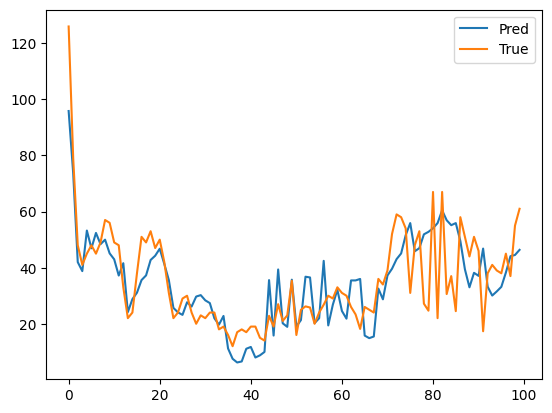

In [10]:
plt.plot(Y[:100, 30], label='Pred')
plt.plot(X[:100, 30], label='True')
plt.legend()

In [12]:
import pandas as pd

cols = [1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036]
df = pd.DataFrame(Y, columns=cols)

In [13]:
df

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036
0,113.025253,108.408302,112.931374,112.181458,115.740158,112.161850,110.939270,111.348145,109.179138,115.939301,...,105.461693,120.474991,109.273499,103.242531,95.860725,53.234177,139.727753,100.489380,99.275352,107.146523
1,69.320930,63.203522,70.149155,71.415024,77.912086,69.032410,69.397240,72.930443,69.645401,76.253593,...,68.238052,79.688171,73.280228,62.769829,73.661789,53.234177,66.584465,84.848091,80.881310,90.720421
2,63.453754,57.016869,63.736298,64.564644,69.037140,62.070396,63.771221,68.643250,62.246971,69.357071,...,60.772148,58.280144,54.750450,49.489330,41.988255,53.234177,50.509556,76.296150,69.647774,80.240501
3,54.332512,47.723881,52.503048,53.978569,59.630978,52.853390,54.940155,59.464470,53.028854,60.552696,...,60.588264,58.781044,54.750450,44.246044,38.773205,53.234177,54.178673,70.606499,58.662186,66.988174
4,46.029125,40.065086,45.225998,46.338741,53.959255,45.323898,47.249985,51.589737,45.499313,52.279369,...,55.322437,53.512329,48.221264,44.253887,53.243568,53.234177,52.007130,68.190430,56.070370,61.295284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,73.103340,69.510803,76.245773,76.989876,81.798058,75.013840,76.419266,79.207169,75.501587,82.149940,...,60.805611,59.156765,54.750450,58.559406,55.898781,53.234177,72.167595,89.685730,85.841843,92.266953
2924,72.821526,69.169357,75.917938,76.698242,81.561371,74.601067,75.908844,78.737129,75.039200,81.645645,...,60.805611,59.156765,54.750450,58.559406,55.898781,53.234177,72.167595,89.105225,85.841843,92.266953
2925,74.110634,65.704063,70.987541,71.342155,77.000908,70.968597,71.815987,73.146843,70.125412,75.454399,...,68.499657,62.927536,75.289520,70.775383,80.620651,57.371140,71.230156,86.644150,84.749634,91.921082
2926,67.235832,58.262508,61.692673,59.775963,64.251770,62.335381,62.227554,64.753105,58.780159,64.949837,...,76.122803,67.136566,119.579346,80.580963,102.489426,67.066269,70.282578,66.190269,57.189289,65.469757


In [14]:
df.to_csv('GRINAirQualityPrediction.csv', index=False)